# GC 3D analysis (CTA DC-1)

This tutorial shows how to run a 3D map-based analysis using DC-1 observations of the Galactic center region with CTA. For this tutorial the $CTADATA environment variable will be used (see https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki/Getting_data ). More information about CTA DC-1 can be found in https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki as well as in the Gammapy "cta_1dc_introduction" and "cta_data_analysis" tutorial notebooks.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf, make_mean_edisp
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.cube import MapMaker, MapEvaluator, PSFKernel, MapFit
from gammapy.cube.models import SkyModel,SkyDiffuseCube
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw
from gammapy.image.models import SkyGaussian, SkyPointSource
from regions import CircleSkyRegion

In [3]:
path = os.path.expandvars("$CTADATA") 

if not os.path.exists(path):
    raise Exception("$CTADATA repository not found!")
else:
    print("Great! your setup is correct.")
    !gammapy info --no-envvar --no-system

Great! your setup is correct.

Gammapy package:

	path                   : /home/cta-liverpool/git/gammapy/gammapy 
	version                : 0.9.dev7759 
	githash                : f9dfc39d0bd8412815b4e409eab5fc7ab5bb9fcf 


Other packages:

	numpy                  : 1.15.2     
	scipy                  : 1.1.0      
	matplotlib             : 2.1.1      
	cython                 : 0.28.5     
	astropy                : 3.0.4      
	astropy_healpix        : 0.2        
	reproject              : 0.4        
	sherpa                 : 4.10.0     
	pytest                 : 3.8.2      
	sphinx                 : 1.8.1      
	healpy                 : 1.12.4     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : not installed 
	uncertainties          : 3.0.2      



## Prepare modeling input data

### Prepare input maps

We first use the `DataStore` object to access the CTA observations and, after applying some selection cuts, we pass the selected observations ID's to the `.obs_list()` method:

In [4]:
# Define which data to use and print some information
data_store = DataStore.from_dir('$CTADATA/index/gps')
data_store.info()
print('Total observation time (hours): ', data_store.obs_table['ONTIME'].sum() / 3600)
print('Observation table: ', data_store.obs_table.colnames)
print('HDU table: ', data_store.hdu_table.colnames)

Data store:
HDU index table:
BASE_DIR: /home/cta-liverpool/CTA_analysis/DC/1dc/index/gps
Rows: 19620
OBS_ID: 110000 -- 113269
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Observatory name: 'N/A'
Number of observations: 3270
Total observation time (hours):  1635.0
Observation table:  ['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'N_TELS', 'OBJECT', 'CALDB', 'IRF', 'EVENTS_FILENAME', 'EVENT_COUNT']
HDU table:  ['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME']


In [5]:
# Select some observations from these dataset
table = data_store.obs_table
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
offset = pos_target.separation(pos_obs).deg
mask = (0 < offset) & (offset < 3)
table = table[mask]

In [6]:
# Print total number and ID's of observation list
print("{} observations selected:".format(len(table)))
table["OBS_ID"]
obs_id = table["OBS_ID"].tolist()
obs_list = data_store.get_observations(obs_id)
print(obs_id)

57 observations selected:
[110380, 110381, 110382, 110383, 110384, 110385, 110386, 110387, 110388, 110389, 110390, 110391, 110392, 110393, 110394, 110395, 110396, 110397, 110398, 111140, 111141, 111142, 111143, 111144, 111145, 111146, 111147, 111148, 111149, 111150, 111151, 111152, 111153, 111154, 111155, 111156, 111157, 111158, 111159, 111160, 111161, 111162, 111163, 111164, 111165, 111166, 111167, 111168, 111169, 111170, 111171, 111172, 111173, 111174, 111175, 111176, 111177]


Now we define a reference geometry for our analysis, We choose a WCS based gemoetry with a binsize of 0.02 deg and also define an energy axis: 

In [7]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

The `MapMaker` object is initialized with this reference geometry and a field of view cut of 4 deg:

In [8]:
%%time
maker = MapMaker(geom, offset_max=4. * u.deg)
maps = maker.run(obs_list)

CPU times: user 2min 16s, sys: 12.6 s, total: 2min 29s
Wall time: 2min 29s


The maps are prepared by calling the `.run()` method and passing the observation list `obs_list`. The `.run()` method returns a Python `dict` containing a `counts`, `background` and `exposure` map:

In [9]:
print(maps)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
, 'exposure': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : 'm2 s' 
	dtype : float32 
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
}


This is what the summed counts image looks like:

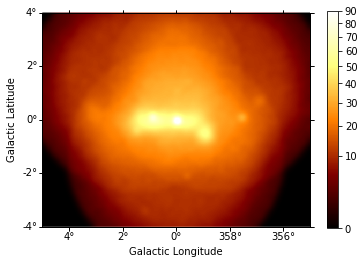

In [10]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax = 90);

This is the background image:

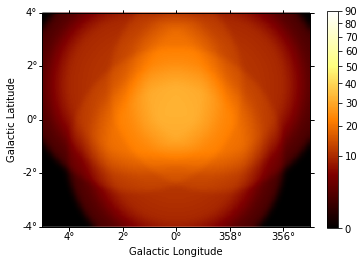

In [11]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax=90);

And this one the exposure image:

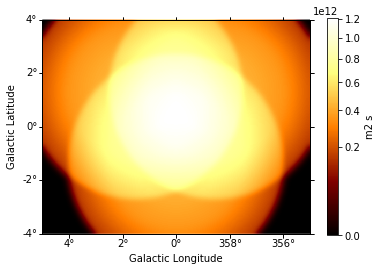

In [12]:
exposure = maps["exposure"].sum_over_axes()
exposure.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True);

We can also compute an excess image just with  a few lines of code:

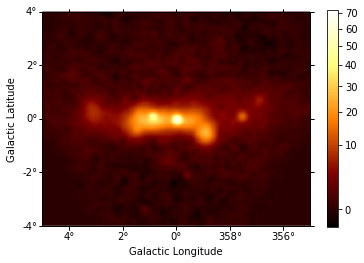

In [13]:
excess = Map.from_geom(geom.to_image())
excess.data = counts.data - background.data
excess.smooth(5).plot(stretch="sqrt", add_cbar=True);

For a more realistic excess plot we can also take into account the diffuse galactic emission. Note that a cutoff of the map can speed things up here if this notebook is going to be ran more than once! A cutout example can be found in https://github.com/gammapy/gammapy-extra/blob/master/datasets/fermi_3fhl/make.py

In [14]:
diffuse_gal = Map.read(
    "$CTADATA/models/cube_iem.fits.gz"
)

In [15]:
print("Diffuse image: ",diffuse_gal.geom)
print("counts: ",maps["counts"].geom)

Diffuse image:  WcsGeom

	axes       : lon, lat, energy
	shape      : (7200, 481, 32)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 360.0 x 24.1 deg

counts:  WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg



We see that the geometry of the images is completely different, so we need to apply our geometric configuration to the diffuse emission file:

In [16]:
coord = maps["counts"].geom.get_coord()

data = diffuse_gal.interp_by_coord(
    {
        "skycoord": coord.skycoord,
        "energy": coord["energy"]
        * maps["counts"].geom.get_axis_by_name("energy").unit,
    },
    interp=3,
)
diffuse_galactic = WcsNDMap(
    maps['counts'].geom, data
)
print("Before: \n",diffuse_gal.geom)
print("Now (same as maps): \n", diffuse_galactic.geom)

Before: 
 WcsGeom

	axes       : lon, lat, energy
	shape      : (7200, 481, 32)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 360.0 x 24.1 deg

Now (same as maps): 
 WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg



WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (500, 400)
	ndim  : 2
	unit  : '' 
	dtype : float64 



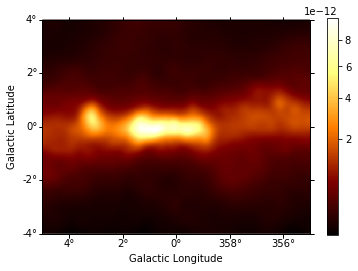

In [17]:
#diffuse_galactic.slice_by_idx({"energy": 0}).plot(add_cbar=True); # this can be used to check image at different energy bins
diffuse = diffuse_galactic.sum_over_axes()
diffuse.smooth(5).plot(stretch="sqrt", add_cbar=True);
print(diffuse)

We now multiply the exposure for this diffuse emission to subtract the result from the counts along with the background.

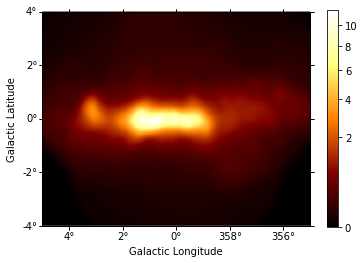

In [18]:
combination = Map.from_geom(geom.to_image())
combination.data = diffuse.data*exposure.data
combination.smooth(5).plot(stretch="sqrt", add_cbar=True);

We can plot then the excess image subtracting now the effect of the diffuse galactic emission.

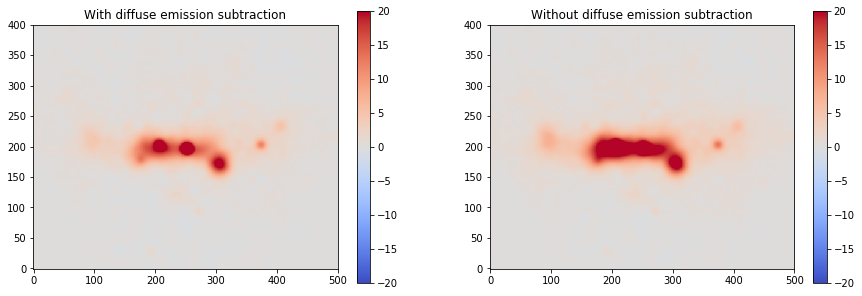

In [19]:
excess2 = Map.from_geom(geom.to_image())
excess2.data = counts.data - background.data - combination.data

fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].set_title("With diffuse emission subtraction")
axs[1].set_title("Without diffuse emission subtraction")
excess2.smooth(5).plot(cmap="coolwarm", vmin = -20, vmax = 20, add_cbar=True, ax=axs[0]);
excess.smooth(5).plot(cmap="coolwarm", vmin = -20, vmax = 20, add_cbar=True, ax=axs[1]);

### Prepare IRFs

To estimate the mean PSF across all observations at a given source position `src_pos`, we use `make_mean_psf()`:

In [20]:
# mean PSF
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = make_mean_psf(obs_list, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")

To estimate the mean energy dispersion across all observations at a given source position `src_pos`, we use `make_mean_edisp()`:

In [21]:
# define energy grid
energy = energy_axis.edges * energy_axis.unit

# mean edisp
edisp = make_mean_edisp(
    obs_list, position=src_pos, e_true=energy, e_reco=energy
)

### Save maps and IRFs to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [22]:
path = Path("analysis_3d_DC1")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `.write()` methods:

In [23]:
# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp.write(str(path / "edisp.fits"), overwrite=True)

## Likelihood fit

### Reading maps and IRFs
As first step we read in the maps and IRFs that we have saved to disk again:

In [24]:
# read maps
maps = {
    "counts": Map.read(str(path / "counts.fits")),
    "background": Map.read(str(path / "background.fits")),
    "exposure": Map.read(str(path / "exposure.fits")),
}

# read IRFs
psf_kernel = PSFKernel.read(str(path / "psf.fits"))
edisp = EnergyDispersion.read(str(path / "edisp.fits"))

Let's cut out only part of the maps, so that we the fitting step does not take so long (we go from left to right one):

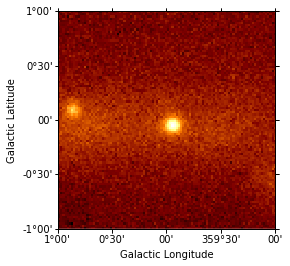

In [25]:
cmaps = {
    name: m.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 2 * u.deg)
    for name, m in maps.items()
}
cmaps["counts"].sum_over_axes().plot(stretch="sqrt");

Insted of the complete one, which was:

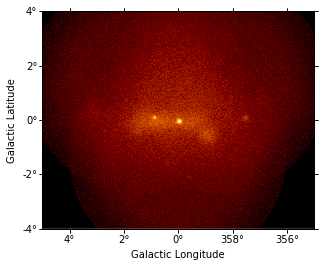

In [26]:
counts.plot(stretch="sqrt");

### Fit mask

To select a certain spatial region and/or energy range for the fit we can create a fit mask:

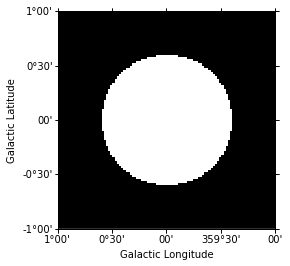

In [27]:
mask = Map.from_geom(cmaps["counts"].geom)

region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
mask.data = mask.geom.region_mask([region])

mask.get_image_by_idx((0,)).plot();

In addition we also exclude the range below 0.3 TeV for the fit:

In [28]:
coords = mask.geom.get_coord()
mask.data &= coords["energy"] > 0.3

### Model fit

No we are ready for the actual likelihood fit. We first define the model as a combination of a point source with an exponential cutt off power law:

In [29]:
spatial_model = SkyPointSource(lon_0="0.01 deg", lat_0="0.01 deg")
spectral_model = ExponentialCutoffPowerLaw(
    index=2 * u.Unit(''),
    amplitude=1e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1. * u.TeV,
    lambda_=1 / u.TeV
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Now we set up the `MapFit` object by passing the prepared maps, IRFs as well as the model:

In [30]:
fit = MapFit(
    model=model,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    mask=mask,
    psf=psf_kernel,
    edisp=edisp,
)

No we run the model fit:

In [31]:
%%time
result = fit.run(optimize_opts={"print_level": 1})

FCN = -19271.633424645435 
 TOTAL NCALL = 343 
 NCALLS = 343 
 
 
 EDM = 4.392225026316357e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,-5.56465,0.0490795,,,,,No
1,par_001_lat_0,-4.54973,0.0498666,,,,,No
2,par_002_index,2.28185,0.0316819,,,,,No
3,par_003_amplitude,2.96359,0.0848023,,,,,No
4,par_004_reference,1,1,,,,,Yes
5,par_005_lambda_,0.0415331,0.0165148,,,,,No


CPU times: user 5.8 s, sys: 4.42 ms, total: 5.81 s
Wall time: 5.81 s


In [32]:
print(result.model)

SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value      error   unit min max
	----- ---------- --------- ---- --- ---
	lon_0 -5.565e-02 4.908e-04  deg nan nan
	lat_0 -4.550e-02 4.987e-04  deg nan nan

Covariance: 

	 name   lon_0     lat_0  
	----- --------- ---------
	lon_0 2.409e-07 6.725e-11
	lat_0 6.725e-11 2.487e-07

spectral_model = ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error        unit      min max
	--------- --------- --------- -------------- --- ---
	    index 2.282e+00 3.168e-02                nan nan
	amplitude 2.964e-12 8.480e-14 cm-2 s-1 TeV-1 nan nan
	reference 1.000e+00 0.000e+00            TeV nan nan
	  lambda_ 4.153e-02 1.651e-02          TeV-1 nan nan

Covariance: 

	   name     index    amplitude  reference  lambda_  
	--------- ---------- ---------- --------- ----------
	    index  1.004e-03 -2.174e-15 0.000e+00 -4.719e-04
	amplitude -2.174e-15  7.191e-27 0.000e+00  1.262e-15
	reference  0.000e+00  0.000e+00 0.000e+00 

### Check model fit

We check the model fit by computing a residual image. For this we first get the number of predicted counts from the fit evaluator:

In [33]:
npred = fit.evaluator.compute_npred()

And compute a residual image:

In [34]:
residual = Map.from_geom(cmaps["counts"].geom)
residual.data = cmaps["counts"].data - npred.data

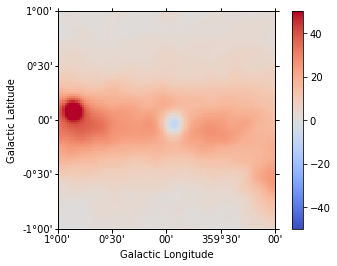

In [35]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -50, vmax=50, add_cbar=True
);

Apparently our model should be improved by adding a component for diffuse Galactic emission and at least one second point
source (see exercises at the end of the notebook).

We can also plot the best fit spectrum:

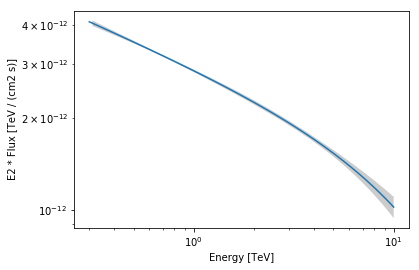

In [36]:
spec = result.model.spectral_model
energy_range = [0.3, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

This result can be compared with the model used for the 1DC:

In [37]:
dc1_model = ExponentialCutoffPowerLaw(
    index = 2.14 * u.Unit(''),
    amplitude = 2.55e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference= 1. * u.TeV,
    lambda_= 0.0934 / u.TeV
)
dc1_model.parameters.to_table()

name,value,error,unit,min,max
str9,float64,float64,str14,float64,float64
index,2.140e+00,nan,,nan,nan
amplitude,2.550e-12,nan,cm-2 s-1 TeV-1,nan,nan
reference,1.000e+00,nan,TeV,nan,nan
lambda_,9.340e-02,nan,TeV-1,nan,nan


In [38]:
result.model.parameters.to_table()

name,value,error,unit,min,max
str9,float64,float64,str14,float64,float64
lon_0,-5.565e-02,4.908e-04,deg,nan,nan
lat_0,-4.550e-02,4.987e-04,deg,nan,nan
index,2.282e+00,3.168e-02,,nan,nan
amplitude,2.964e-12,8.480e-14,cm-2 s-1 TeV-1,nan,nan
reference,1.000e+00,0.000e+00,TeV,nan,nan
lambda_,4.153e-02,1.651e-02,TeV-1,nan,nan


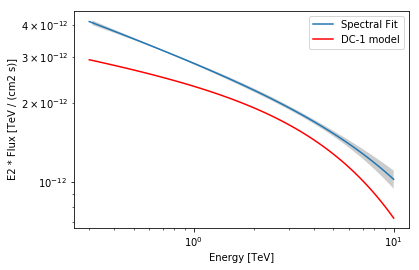

In [39]:
spec = result.model.spectral_model
energy_range = [0.3, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
ax = dc1_model.plot(energy_range, energy_power=2, color='red')
ax.legend(['Spectral Fit', 'DC-1 model'])

We can see this discrepancy between the fit and the DC-1 model due to the diffuse emission... so let's improve this.

### Adding galactic diffuse emission to model

We use both models at the same time, our diffuse model (taken from DC-1 iem file) and our previous model for the central source (note that we are not constraining the fit with any mask this time).

In [40]:
diffuse_model = SkyDiffuseCube.read("$CTADATA/models/cube_iem.fits.gz")

In [41]:
combined_fit = MapFit(
    model=diffuse_model+model,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    psf=psf_kernel
)

In [42]:
%%time
result_combined=combined_fit.run()

CPU times: user 2min 15s, sys: 1min 29s, total: 3min 45s
Wall time: 3min 45s


In [43]:
print(result_combined.model)

CompoundSkyModel
    Component 1 : <gammapy.cube.models.SkyDiffuseCube object at 0x7f4e040a7160>
    Component 2 : SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value    error unit min max
	----- ---------- ----- ---- --- ---
	lon_0 -5.504e-02   nan  deg nan nan
	lat_0 -4.759e-02   nan  deg nan nan

spectral_model = ExponentialCutoffPowerLaw

Parameters: 

	   name     value   error      unit      min max
	--------- --------- ----- -------------- --- ---
	    index 2.114e+00   nan                nan nan
	amplitude 2.563e-12   nan cm-2 s-1 TeV-1 nan nan
	reference 1.000e+00   nan            TeV nan nan
	  lambda_ 1.047e-01   nan          TeV-1 nan nan

    Operator : <built-in function add>


As we can see we have now two components in our model, and we can access them separately.

In [44]:
#Checking normalization value (the closer to 1 the better)
print("First model (SkyDiffuseCube): ",result_combined.model.model1.parameters)
print("Second model (SkyModel): ",result_combined.model.model2.parameters)

First model (SkyDiffuseCube):  Parameters
Parameter(name='norm', value=1.0963411032990302, factor=1.0963411032990302, scale=1.0, unit='', min=nan, max=nan, frozen=False)

Covariance: 
None
Second model (SkyModel):  Parameters
Parameter(name='lon_0', value=-0.05504100753797427, factor=-5.504100753797427, scale=0.01, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='lat_0', value=-0.0475863157328381, factor=-4.75863157328381, scale=0.01, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='index', value=2.1142426166211474, factor=2.1142426166211474, scale=1.0, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=2.563222430608934e-12, factor=2.563222430608934, scale=1e-12, unit='cm-2 s-1 TeV-1', min=nan, max=nan, frozen=False)
Parameter(name='reference', value=1.0, factor=1.0, scale=1.0, unit='TeV', min=nan, max=nan, frozen=True)
Parameter(name='lambda_', value=0.10469309966013633, factor=0.10469309966013633, scale=1.0, unit='TeV-1', min=nan, max=na

The normalization parameter is 0.85, which is quite good... We can now plot the residual image considering this improved model.

In [45]:
npred_combined = combined_fit.evaluator.compute_npred()

residual2 = Map.from_geom(cmaps["counts"].geom)
residual2.data = cmaps["counts"].data - npred_combined.data

Just as a comparison, we can plot our previous residual map (left) and the new one (right) with the same scale:

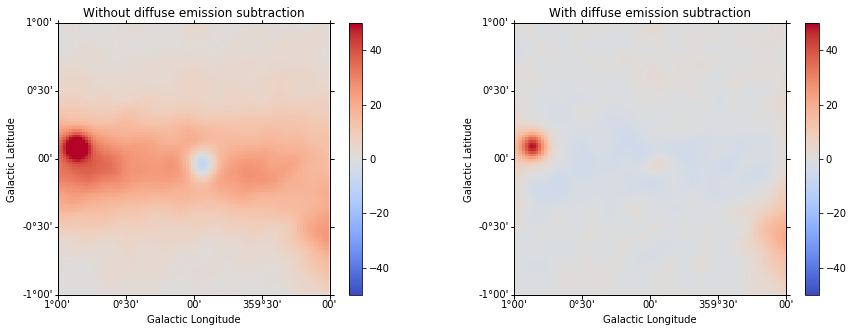

In [46]:
plt.figure(figsize=(15, 5))
ax_1 = plt.subplot(121, projection=residual.geom.wcs)
ax_2 = plt.subplot(122, projection=residual.geom.wcs)

ax_1.set_title("Without diffuse emission subtraction")
ax_2.set_title("With diffuse emission subtraction")

residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -50, vmax=50, add_cbar=True, ax=ax_1
);
residual2.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -50, vmax=50, add_cbar=True, ax=ax_2
);

Finally we can compare again our model (including now the diffuse emission) with the one used for the DC-1:

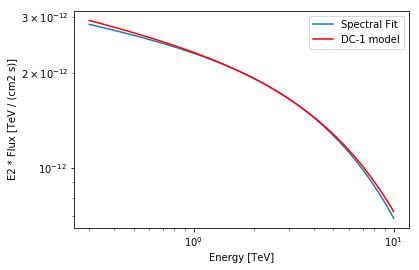

In [47]:
spec2 = result_combined.model.model2.spectral_model
ax = spec2.plot(energy_range=energy_range, energy_power=2, label='Spectral Fit')
dc1_model.plot(energy_range, energy_power=2, color='red', label='DC-1 model', ax=ax)
plt.legend()

Results seems to be better (but not perfect yet). As an example, let's compare flux values at 1TeV for both models:

In [48]:
spec2(energy=1*u.TeV)

<Quantity 2.30844036e-12 1 / (cm2 s TeV)>

In [49]:
dc1_model(energy=1*u.TeV)

<Quantity 2.32261419e-12 1 / (cm2 s TeV)>

Next step to improve our model even more would be getting rid of the other bright source (G0.9+0.1).

## Exercises

* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.